# NLP with Disaster Tweets Competition

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). But, it’s not always clear whether a person’s words are actually announcing a disaster.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

## Introduction

In [37]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing
import re # for regular expression

import spacy
nlp = en_core_web_lg.load()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train_filepath = 'train.csv'
test_filepath = 'test.csv'

train_data = pd.read_csv(train_filepath, index_col='id', encoding='utf_8')
test_data = pd.read_csv(test_filepath, index_col='id', encoding='utf_8')

print('>>> Sucessfully imported all libraries and dataset')

>>> Sucessfully imported all libraries and dataset


## I. Exploratory Data Analysis

In [38]:
train_data.sample(10)

,keyword,location,text,target
id,,,,
3778,destruction,Yooooooo,What's happening? A destruction indeed http://...,0
8021,refugees,St PetersburgFL,'imagine an entire aisle dedicated to making p...,0
10822,wrecked,Glasgow,@Caitsroberts see U the night wee bArra to get...,0
7987,razed,NaN,The Latest: More Homes Razed by Northern Calif...,1
1106,blew%20up,Florida,@iphooey @TIME Ironically Michele Bachmann bro...,0
7580,outbreak,Anywhere,Families to sue over Legionnaires: More than 4...,1
9395,survivors,NaN,Dying with debt can be costly for survivors,0
10030,twister,NaN,Bulgarian Tittie Twister By NoEmotion Produced...,0
5856,hailstorm,"Calgary, Alberta",Ready for my close up... Errrr nope!! #notgoin...,1


In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


There are 7613 rows and 4 columns. The target column we want to predict is target (Classification problem)

In [40]:
print('Duplicate count in train data:', train_data.duplicated().sum())
print('Duplicate count in test data:', test_data.duplicated().sum())

Duplicate count in train data: 52
Duplicate count in test data: 11


There are 52 duplicated rows that need to be removed in the train data.

In [41]:
train_data.isnull().sum().sort_values(ascending=False)

location    2533
keyword       61
target         0
text           0
dtype: int64

In [42]:
test_data.isnull().sum().sort_values(ascending=False)

location    1105
keyword       26
text           0
dtype: int64

There are a lot of missing values location in both dataset. We will fill them with 'no_location'

Missing values in keyword requires more attention. It makes no sense to fill with the most frequent value or anything else, so we will fill with 'no_keyword'.

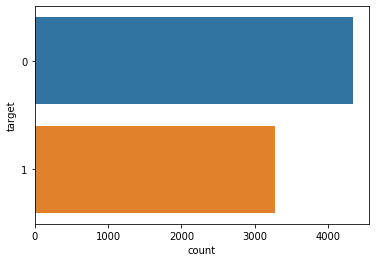

In [43]:
sns.countplot(y=train_data['target'])

The target values are fairly balanced in the train dataset.

### Keywords

In [44]:
print('Unique keyword count in train data:', train_data.keyword.nunique())
print('Unique keyword count in test data:', test_data.keyword.nunique())

print (set(train_data.keyword.unique()) - set(test_data.keyword.unique()))

Unique keyword count in train data: 221
Unique keyword count in test data: 221
set()


Both dataset have the same 221 keywords.

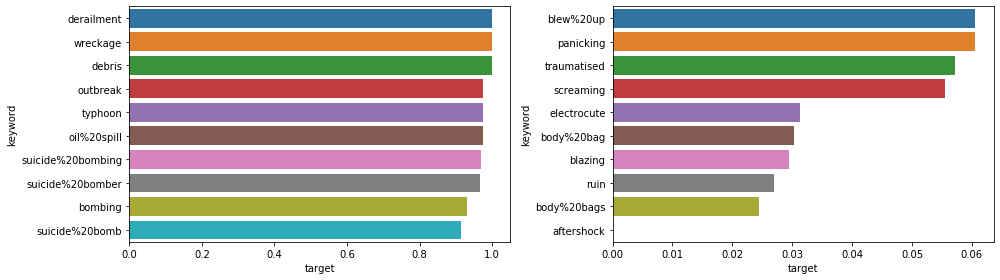

In [45]:
train_data_groupby_keyword = train_data.groupby('keyword')['target'].mean().sort_values(ascending=False)

plt.figure(figsize=(14,4))

plt.subplot(121)
sns.barplot(x=train_data_groupby_keyword.head(10), y=train_data_groupby_keyword.head(10).index)

plt.subplot(122)
sns.barplot(x=train_data_groupby_keyword.tail(10), y=train_data_groupby_keyword.tail(10).index)

plt.tight_layout()

Some keywords seem to be linked with the occurence of a disaster while some others not.

## II. Data Cleaning and Preprocessing

### Dropping duplicate rows

In [124]:
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

train_data_copy = train_data_copy.drop_duplicates(keep='first')
# test_data_copy = test_data_copy.drop_duplicates(keep='first')

In [125]:
print('train_data_copy shape:', train_data_copy.shape)
# print('test_data_copy shape:', test_data_copy.shape)

train_data_copy shape: (7561, 4)


### Dealing with missing values

In [126]:
train_data_copy['keyword'] = train_data_copy['keyword'].fillna('no_keyword')
test_data_copy['keyword'] = test_data_copy['keyword'].fillna('no_keyword')

train_data_copy['location'] = train_data_copy['location'].fillna('no_location')
test_data_copy['location'] = test_data_copy['location'].fillna('no_location')

In [127]:
train_data_copy.isnull().sum().sort_values(ascending=False)

target      0
text        0
location    0
keyword     0
dtype: int64

In [128]:
test_data_copy.isnull().sum().sort_values(ascending=False)

text        0
location    0
keyword     0
dtype: int64

### Text Cleaning

In [129]:
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra 
    text = text.lower() # convert to lower case
    return text

train_data_copy['text_clean'] = train_data_copy['text'].apply(lambda x: clean_text(x))
test_data_copy['text_clean'] = test_data_copy['text'].apply(lambda x: clean_text(x))

print('>>> Text cleaning done')

>>> Text cleaning done


### Embedding

In [130]:
print(nlp.pipe_names)

['tagger', 'parser', 'ner']


In [131]:
with nlp.disable_pipes():
    train_vectors = {}
    for idx, tweet in train_data_copy.iterrows():
        train_vectors[idx] = nlp(tweet['text_clean']).vector
        
with nlp.disable_pipes():
    test_vectors = {}
    for idx, tweet in test_data_copy.iterrows():
        test_vectors[idx] = nlp(tweet['text_clean']).vector
        
train_vectors_df = pd.DataFrame(train_vectors).transpose()
test_vectors_df = pd.DataFrame(test_vectors).transpose()
    
print('>>> Embedding done')

>>> Embedding done


In [132]:
print('train_vectors shape:', train_vectors_df.shape)
print('test_vectors shape:', test_vectors_df.shape)

train_vectors shape: (7561, 300)
test_vectors shape: (3263, 300)


### Encoding

In [133]:
import category_encoders as ce

# Target encoding
features = ['keyword', 'location']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train_data_copy[features], train_data_copy['target'])

train_data_copy = train_data_copy.join(encoder.transform(train_data_copy[features]).add_suffix('_enc'))
test_data_copy = test_data_copy.join(encoder.transform(test_data_copy[features]).add_suffix('_enc'))

print('>>> Target encoding done')

>>> Target encoding done


In [134]:
# Joining the dataframes together
train = train_data_copy.join(train_vectors_df)
test = test_data_copy.join(test_vectors_df)

print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (7561, 307)
test shape: (3263, 306)


### Dropping features

In [135]:
cols_drop = ['keyword', 'location', 'text', 'text_clean']

train = train.drop(cols_drop, axis=1)
test = test.drop(cols_drop, axis=1)

print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (7561, 303)
test shape: (3263, 302)


## III. Model Selection

In [161]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

X = train.drop(['target'], axis=1)
y = train.target
X_test = test

### 1. Testing different models

#### SVC

In [167]:
svc_model = LinearSVC(C=0.07, dual=False, penalty='l1' ,max_iter=10000)
svc_accuracy = cross_val_score(svc_model, X, y, cv=5)

print('SVC Mean Accuracy:', svc_accuracy.mean())

SVC Mean Accuracy: 0.8132577346424424


In [140]:
# # SVC - Grid Search
# svc_param_grid ={
#     'C': [0.03,0.05,0.07],
#     'dual': [False],
#     'penalty': ['l1'],
#     'max_iter': [10000]
# }

# svc_model = LinearSVC()
# svc_grid = GridSearchCV(estimator=svc_model, param_grid=svc_param_grid, cv=5, verbose=2, n_jobs=-1)
# svc_grid.fit(X, y)

# print('Best params:', svc_grid.best_params_)
# print('Best score:', svc_grid.best_score_)

#### ANN

In [188]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Model, backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, Embedding, Input
from tensorflow.keras.callbacks import EarlyStopping

print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

TensorFlow version: 2.2.0
Keras version: 2.3.0-tf


In [237]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ann_model = Sequential ([
#     Dense(100, activation='relu', kernel_initializer='he_uniform',
#           input_shape=X_train.shape[1:]),
#     Dropout(rate=0.1),
#     Dense(50, activation='relu', kernel_initializer='he_uniform'),
#     Dense(1, activation='sigmoid')
# ])

ann_model = Sequential([
    Dense(100, activation='relu', kernel_initializer='he_uniform',
           input_shape=X_train.shape[1:]),
    Dropout(rate=0.1),
    Dense(100, activation='relu'),
    Dropout(rate=0.1),
    Dense(100, activation='relu'),
    Dropout(rate=0.1),
    Dense(50, activation='relu'),
    Dropout(rate=0.1),
    Dense(1, activation='sigmoid')
])

ann_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

history = ann_model.fit(X_train, y_train, epochs=50, 
                        validation_data=(X_valid, y_valid), 
                        callbacks=[early_stopping_cb])

ann_model.save('binary_classification_model.h5')

Epoch 1/50
189/189 [==============================] - 0s 1ms/step - loss: 0.4735 - accuracy: 0.7803 - val_loss: 0.4225 - val_accuracy: 0.8209
Epoch 2/50
189/189 [==============================] - 0s 1ms/step - loss: 0.4076 - accuracy: 0.8236 - val_loss: 0.4151 - val_accuracy: 0.8182
Epoch 3/50
189/189 [==============================] - 0s 1ms/step - loss: 0.3865 - accuracy: 0.8318 - val_loss: 0.4297 - val_accuracy: 0.8268
Epoch 4/50
189/189 [==============================] - 0s 1ms/step - loss: 0.3627 - accuracy: 0.8434 - val_loss: 0.4365 - val_accuracy: 0.8096
Epoch 5/50
189/189 [==============================] - 0s 1ms/step - loss: 0.3431 - accuracy: 0.8532 - val_loss: 0.4468 - val_accuracy: 0.8189
Epoch 6/50
189/189 [==============================] - 0s 1ms/step - loss: 0.3259 - accuracy: 0.8641 - val_loss: 0.4506 - val_accuracy: 0.8163
Epoch 7/50
189/189 [==============================] - 0s 1ms/step - loss: 0.3052 - accuracy: 0.8717 - val_loss: 0.4575 - val_accuracy: 0.8182
Epoch 

Text(0.5, 1.0, 'Learning curves')

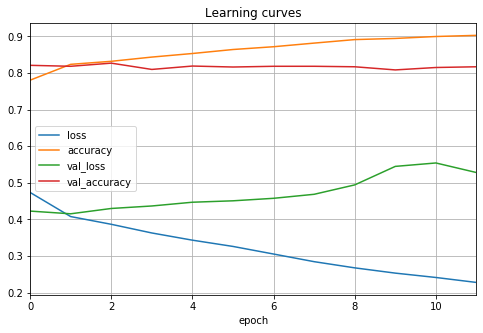

In [238]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('epoch')
plt.title('Learning curves')

### 2. Performance measures

In [142]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

#### Confusion matrix

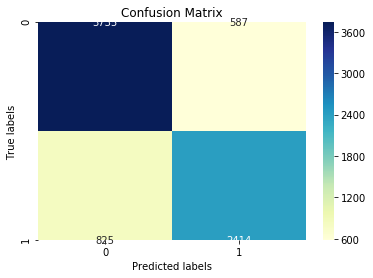

In [144]:
svc_model = LinearSVC(C=0.07, dual=False, penalty='l1' ,max_iter=10000)
y_pred = cross_val_predict(svc_model, X, y, cv=5)

svc_confusion = confusion_matrix(y_train, y_pred)

def plot_confusion_matrix(matrix):
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap='YlGnBu')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1']);
    
plot_confusion_matrix(svc_confusion)

#### Precision and Recall

In [145]:
print('SVC precision score:', precision_score(y_pred, y))
print('SVC recall score:', recall_score(y_pred, y))
print('SVC f1 score:', f1_score(y_pred, y))

SVC precision score: 0.7452917567150356
SVC recall score: 0.8043985338220593
SVC f1 score: 0.7737179487179487


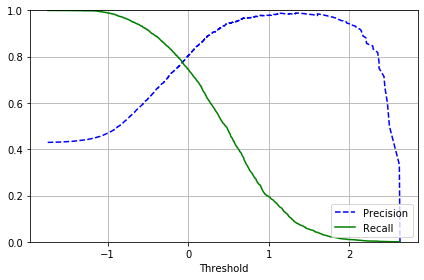

In [146]:
y_pred = cross_val_predict(svc_model, X, y, cv=5, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y, y_pred)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    ax = plt.subplot()
    ax.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    ax.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    
    ax.set(ylim=[0,1])
    ax.grid(True)
    ax.set_xlabel('Threshold')
    ax.legend(loc='lower right')
    plt.tight_layout()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#### ROC Curve

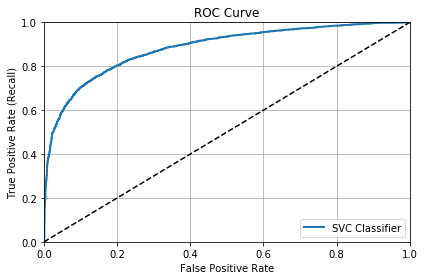

In [147]:
y_proba = cross_val_predict(svc_model, X, y, cv=5, method='decision_function')

fpr, tpr, thresholds = roc_curve(y_train, y)

def plot_roc_curve(fpr, tpr, label=None):
    ax = plt.subplot()
    ax.plot(fpr, tpr, linewidth=2, label=label)
    ax.plot([0,1],[0,1],'k--')

    ax.set(xlim=[0,1],ylim=[0,1])
    ax.grid(True)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Recall)')
    ax.legend(loc='lower right')
    plt.title('ROC Curve')
    plt.tight_layout()
    
plot_roc_curve(fpr, tpr, 'SVC Classifier')

In [148]:
svc_roc_auc = roc_auc_score(y_train, y_pred)

print('SVC ROC AUC Score:', svc_roc_auc)

SVC ROC AUC Score: 0.8835701557215903


## IV. Submission

In [239]:
# Create the final model
# final_model = LinearSVC(C=0.07, dual=False, penalty='l1' ,max_iter=10000)
final_model = load_model('binary_classification_model.h5')

# Fitting the final model using all the data
# final_model.fit(X, y)

In [240]:
final_model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 100)               30300     
_________________________________________________________________
dropout_72 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_73 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_74 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 50)              

In [241]:
# test_predictions = final_model.predict(X_test)
test_predictions = final_model.predict_classes(X_test)[:,0]

output = pd.DataFrame({'id': test_data.index,
                       'target': test_predictions})
output = output.set_index('id')

output.to_csv('submission.csv')

print('>>> CSV created')

>>> CSV created


In [242]:
output.target.value_counts()

0    2206
1    1057
Name: target, dtype: int64